In [ ]:
!pip install sentence_t 

In [ ]:
from pydriller import Repository
import csv
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util

import re
import torch
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
url = "https://github.com/facebookresearch/fairseq"
BUGS_CSV_PATH = "bugs.csv"

In [3]:
bug_fix_keywords = ["fix", "fixes", "fixed", "fix", "bug", "resolves", "issue", "problem"]
bug_fix_commits = []

In [4]:
# Identify bug-fixing commits based on bug_fix_keywords
# Store Commit Hash, Commit Message, Hashes of Parent, Is a merge commit ?, List of modified files in a CSV file

for commit in Repository(url).traverse_commits():
    if any(keyword in commit.msg.lower() for keyword in bug_fix_keywords):
        # Store relevant information
        commit_data = {
            "commit_hash": commit.hash,
            "commit_message": commit.msg,
            "parent_hashes": commit.parents,
            "is_merge": commit.merge,
            "modified_files": [mod_file.filename for mod_file in commit.modified_files]
        }
        bug_fix_commits.append(commit_data)

In [5]:
if os.path.exists("./bugs.csv"):
    os.remove("./bugs.csv")

with open("./bugs.csv", "w", newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=bug_fix_commits[0].keys())
    writer.writeheader()
    for bug_fix_commit in bug_fix_commits:
        writer.writerow(bug_fix_commit)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mamiksik/CommitPredictorT5")
model = AutoModelForSeq2SeqLM.from_pretrained("mamiksik/CommitPredictorT5")

In [ ]:
# Extract the diff for all commits
# Store in a csv with columns hash, message, filename, source code(before), source code (after), Diff, LLM Inference

diff_analysis = []
for commit in Repository(url).traverse_commits():
    diff = commit.diff()
    for file in diff.files:
        before = file.source_code_before
        after = file.source_code_after
        llm_input = f"Diff for {file.filename}:\n{diff}\n\nSource code (before):\n{before}\n\nSource code (after):\n{after}"
        llm_output = model.generate(tokenizer.encode(llm_input, return_tensors="pt"))
        diff_analysis.append({
            "hash": commit.hash,
            "message": commit.message,
            "filename": file.filename,
            "source_code_before": before,
            "source_code_after": after,
            "diff": diff,
            "llm_inference": tokenizer.decode(llm_output[0], skip_special_tokens=True)
        })

In [ ]:
df = pd.DataFrame(diff_analysis)
df.to_csv("diff_analysis.csv", index=False)

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

# Ensure text columns are strings
df["diff"] = df["diff"].fillna("").astype(str)
df["message"] = df["message"].fillna("").astype(str)
df["llm_inference"] = df["llm_inference"].fillna("").astype(str)

emb_diffs = model.encode(df["diff"].tolist(), convert_to_tensor=True)
emb_devs = model.encode(df["message"].tolist(), convert_to_tensor=True)
emb_llms = model.encode(df["llm_inference"].tolist(), convert_to_tensor=True)

# Compute cosine similarities
sims_dev = util.cos_sim(emb_diffs, emb_devs).diagonal()
sims_llm = util.cos_sim(emb_diffs, emb_llms).diagonal()

rectified_messages = []

for i, (dev, llm, diff, s_dev, s_llm) in enumerate(zip(df["message"], df["llm_inference"], df["diff"], sims_dev, sims_llm)):
    
    if s_dev >= s_llm:
        # print("Choosing developer message")
        rectified_messages.append(dev)
    else:
        # print("Choosing LLM inference")
        rectified_messages.append(llm)

df["Rectified Message"] = rectified_messages
df.to_csv("diff_analysis_rectified.csv", index=False)

In [10]:
developers_count = len(df[df["Rectified Message"] == df["message"]])
llm_count = len(df[df["Rectified Message"] == df["llm_inference"]])

In [12]:
print(f"Developer messages chosen: {developers_count}, {developers_count/len(df)*100:.2f}% of total")
print(f"LLM inferences chosen: {llm_count}, {llm_count/len(df)*100:.2f}% of total")

Developer messages chosen: 2418, 59.54% of total
LLM inferences chosen: 1643, 40.46% of total


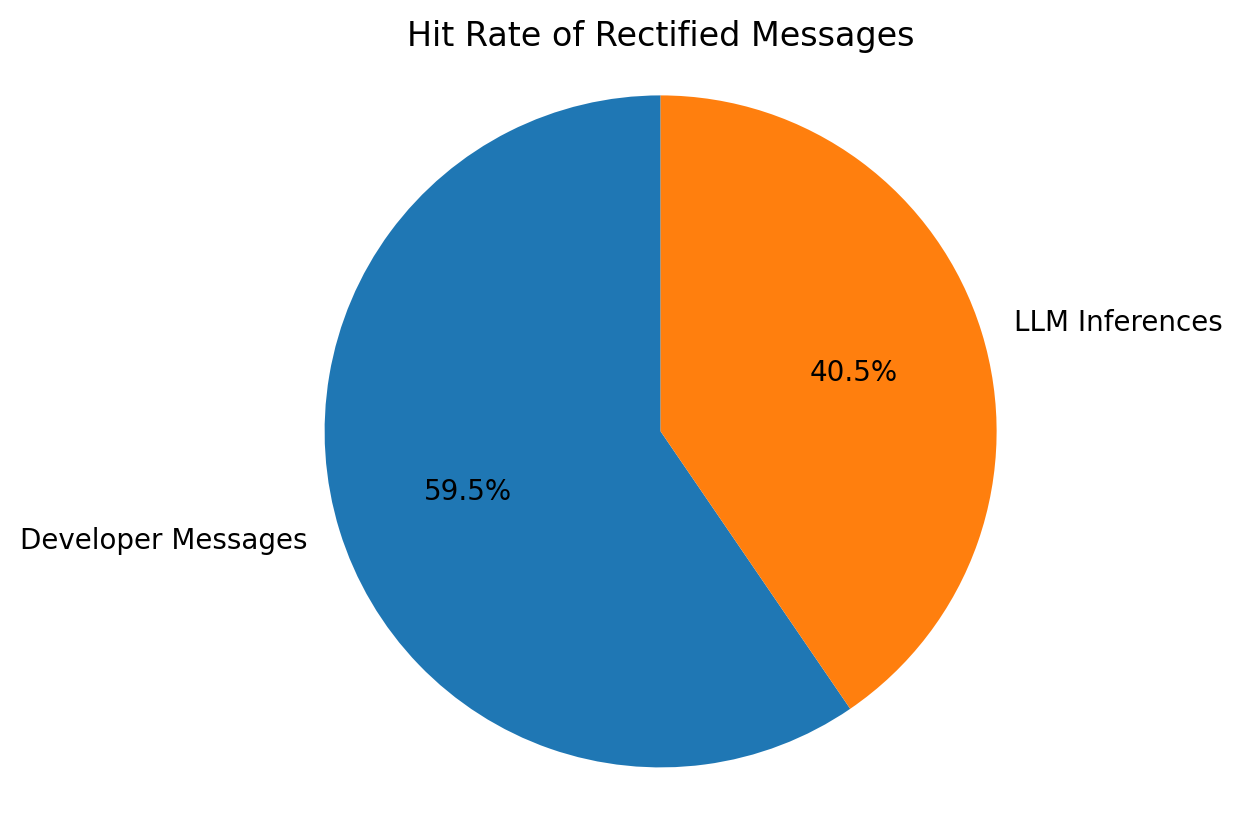

In [18]:
labels = ['Developer Messages', 'LLM Inferences']
sizes = [developers_count, llm_count]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Hit Rate of Rectified Messages")
plt.show()